# Imports and Installs

In [1]:
import numpy as np
import gym
from gym import spaces
import copy
from copy import copy
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
import math
from collections import deque
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Environment

This environment is based off of the MARL Environment Demo written by Professor Alina Vereshchaka

In [2]:
class MAGridWorld(gym.Env):
    
  metadata = { 'render.modes' : ['human', 'rgb_array'] }
        
  def __init__(self, grid):
    self.size = grid
    self.gridSize = (self.size, self.size)
    self.world = np.zeros((self.gridSize))
    self.timestep = None
    self.maxTimestep = 150
    self.nAgents = 2
    #self.dist = int((self.size-1)/(self.nAgents-1))
    self.stepCost = -0.1
    self.obsSpace = spaces.Box(low=0, high=self.size, shape=(self.size, self.size))
    self.actSpace = spaces.Discrete(5)
        
  def reset(self):
    self.agentPos = []
    self.seekerPos = [0,1]
    self.hidderPos = [self.size-1,self.size-1]
    self.goalPos = [0,0]
    self.timestep = 0
    self.done = [False for i in range(self.nAgents)]
    self.agentPos.append(self.hidderPos)
    self.agentPos.append(self.seekerPos)
    #for i in range(self.nAgents):
      #self.agentPos.append([self.size-1, i*self.dist])
      #self.goalPos.append([0, i*self.dist])
      #self.goalPos.reverse()
      #self.goalPos.append([0,2])
    observation = self.agentPos
    return observation
    
  def computeDistance(self, x, y):
    dist = np.abs(x[0]-y[0]) + np.abs(x[1]-y[1])
    return dist
    
  def isInsideGrid(self, pos):
    return (0 <= pos[0] < self.gridSize[0]) and (0 <= pos[1] < self.gridSize[1])

  def isCollision(self, newPos, agent):
    for i in range(self.nAgents):
      if i == agent:
        continue
      elif newPos == self.agentPos[i]:
        return True
      elif (newPos == self.goalPos) and (newPos == self.agentPos[0]):
        return True
        
  def step(self, actions):
    self.timestep += 1
    #win will be -1 if not done, 0 if a tie, 1 if hider wins, and 2 if seeker wins
    win = -1
    oldPos = self.agentPos.copy()
    #print(oldPos)
    rewards = [0 for _ in range(self.nAgents)]               

    for i in range(self.nAgents):
      #print(self.nAgents)
      if (self.done[0] == True) or (self.done[1] == True):
        #print("One or both agents are done")
        break
      #Hider Agent
      if i == 0:
        #print("hider")
        self.updatePos(0, actions[0])
        oldDist = self.computeDistance(oldPos[0], self.goalPos)
        goalDist = self.computeDistance(self.agentPos[0], self.goalPos)
        seekerDist = self.computeDistance(self.agentPos[0], self.agentPos[1])
        oldSeekDist = self.computeDistance(oldPos[0], self.agentPos[1])

        if goalDist < oldDist:
          rewards[0] += -0.1
        elif goalDist > oldDist:
          rewards[0] += -0.5
        elif (goalDist == oldDist) and not self.done[i]:
          rewards[0] += -0.5
            
        if seekerDist < oldDist:
          rewards[0] += -0.5
        elif seekerDist > oldDist:
          rewards[0] += -0.1

        if (self.agentPos[0] == self.goalPos):
          self.done[0] = True
          win = 1
          rewards[0] += 1
        elif (self.agentPos[0] == self.agentPos[1]):
          self.done[0] = True
          rewards[0] += -1
          win = 2
        else:
          self.done[0] = False
      #Move Seeker
      elif i == 1:
        #print('Seeker')
        self.updatePos(1, actions[1])
        #Measure the distance between the hider and seeker
        oldDist = self.computeDistance(oldPos[1], self.agentPos[0])
        newDist = self.computeDistance(self.agentPos[1], self.agentPos[0])

        if newDist < oldDist:
          rewards[1] += -0.1
        elif newDist > oldDist:
          rewards[1] += -0.5
        elif (newDist == oldDist) and not self.done[i]:
          rewards[1] += -0.5

        if (self.agentPos[1] == self.agentPos[0]):
          #print('here')
          self.done[1] = True
          rewards[1] += 1
          win = 2
        else:
          self.done[1] = False
      else:
        print('Not the agent, dummy')
                    
    #print("p")       
    if self.timestep >= self.maxTimestep:
      self.done = [True for i in range(self.nAgents)]
      win = 0
            
    observation = self.agentPos
    info = {}
    return observation, rewards, self.done, win, info #all(done)
    
        
  def updatePos(self, agent, action):
    nextPos = copy(self.agentPos[agent])
    if action == 0: # Down
      nextPos[0] += 1
    elif action == 1: # Up
      nextPos[0] -= 1
    elif action == 2: # Right
      nextPos[1] += 1
    elif action == 3: # Left
      nextPos[1] -= 1
    elif action == 4: # No move
      pass
    else:
      raise Exception('Action is not valid')
        
    if self.isCollision(nextPos, agent):
      for i in range(self.nAgents):  
        self.done[i] = True
    if self.isInsideGrid(nextPos):
      self.agentPos[agent] = nextPos
    else:
      pass
        
            
  def render(self):
    state = np.copy(self.world)
    for i in range(self.nAgents):
      state[tuple(self.agentPos[i])] = 1 - (0.1 * i)
    state[tuple(self.goalPos)] = 1 - (0.1 * 0)
    return plt.imshow(state)

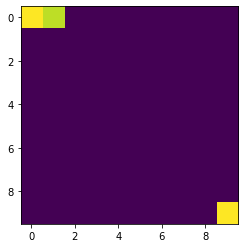

In [3]:
env = MAGridWorld(10)
env.reset()
env.render()

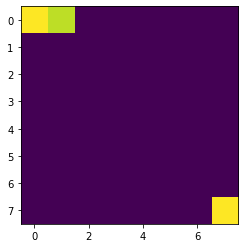

In [4]:
env = MAGridWorld(8)
env.reset()
env.render()

# Actor Critic

In [5]:
class ac_net(nn.Module):
    def __init__(self, out):
        super(ac_net, self).__init__()
        self.fc1 = nn.Linear(env.size**2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, out)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
        
    def forward(self, obsv):
        obsv = torch.tensor(obsv)
        obsv1 = F.relu(self.fc1(obsv))
        obsv2 = F.relu(self.fc2(obsv1))
        obsv3 = self.fc3(obsv2)
        
        return obsv3

In [6]:
class ac_agent():
    def __init__(self):
        #super(ac_net, self).__init__()
        self.gamma = 0.99
        self.actor_lr = 0.0001
        self.critic_lr = 0.0001
        self.actor = ac_net(5)
        self.critic = ac_net(1)
        self.log_probs = None
        
    def step(self, obs):
        actor_policy = F.softmax(self.actor.forward(obs), dim=-1)
        paction = torch.distributions.Categorical(actor_policy)
        action = paction.sample()
        self.log_probs = paction.log_prob(action)
        return action.item()
    
    def learn(self, obs, reward, next_obs, done):
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()
        
        value = self.critic.forward(obs)
        next_val = self.critic.forward(next_obs)
        
        reward = torch.tensor(reward, dtype=torch.float)
        
        delta = reward + self.gamma*(next_val)*(1-int(done)) - value
        aloss = -self.log_probs * delta
        closs = delta**2
        
        (aloss + closs).backward()
        
        self.actor.optimizer.step()
        self.critic.optimizer.step()

## Actor-Critic 10x10 GridWorld

In [7]:
env = MAGridWorld(10)
hider = ac_agent()
seeker = ac_agent()
testStates = [x for x in range(env.size**2)]
testStates = tf.keras.utils.to_categorical(testStates)
reward_total = list()
actList = [0,0]
hideRewTot = []
seekRewTot= []
winList = []
for epi in range(250):
    obs = env.reset()
    hideTotRew = 0
    seekTotRew = 0
    done = [False, False]
    while not any(done):
        hideCurrPos = obs[0][0]*env.size + obs[0][1]
        actList[0] = hider.step(testStates[hideCurrPos])
        seekCurrPos = obs[1][0]*env.size + obs[1][1]
        actList[1] = seeker.step(testStates[seekCurrPos])
        newObs, reward, done,win, info = env.step(actList)
        hideTotRew += reward[0]
        seekTotRew += reward[1]
        newHidePos = newObs[0][0]*env.size + newObs[0][1]
        newSeekPos = newObs[0][0]*env.size + newObs[0][1]
        hider.learn(testStates[hideCurrPos], reward[0], testStates[newHidePos], done[0])
        seeker.learn(testStates[seekCurrPos], reward[1], testStates[newSeekPos], done[1])
        obs = newObs
        
    hideRewTot.append(hideTotRew)
    seekRewTot.append(seekTotRew)
    winList.append(win)
    
    print("Episode: {}".format(epi))

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Ep

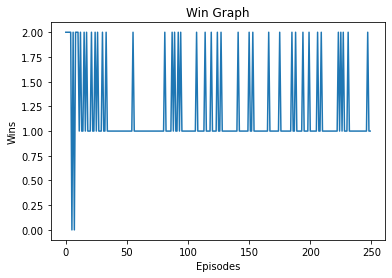

In [8]:
arrEpisodes = np.arange(250)

plt.plot(arrEpisodes, winList)
 
plt.xlabel('Episodes')
plt.ylabel('Wins')
 
plt.title('Win Graph')
 
# function to show the plot
plt.show()

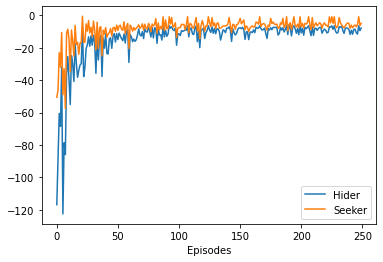

In [9]:
arrEpisodes = np.arange(250)

plt.plot(arrEpisodes, hideRewTot)
plt.plot(arrEpisodes, seekRewTot)
plt.xlabel('Episodes')
plt.legend(["Hider", "Seeker"])
plt.show()

## Actor-Critic 10x10 Evaluation

In [10]:
actList = [0,0]
hideRewTot = []
seekRewTot= []
winList = []
for epi in range(25):
    obs = env.reset()
    hideTotRew = 0
    seekTotRew = 0
    done = [False, False]
    while not any(done):
        hideCurrPos = obs[0][0]*env.size + obs[0][1]
        actList[0] = hider.step(testStates[hideCurrPos])
        seekCurrPos = obs[1][0]*env.size + obs[1][1]
        actList[1] = seeker.step(testStates[seekCurrPos])
        newObs, reward, done,win, info = env.step(actList)
        hideTotRew += reward[0]
        seekTotRew += reward[1]
        
    hideRewTot.append(hideTotRew)
    seekRewTot.append(seekTotRew)
    winList.append(win)
    
    print("Episode: {}".format(epi))

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24


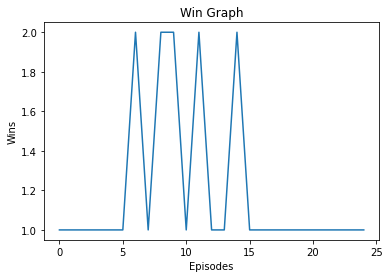

In [11]:
arrEpisodes = np.arange(25)

plt.plot(arrEpisodes, winList)
 
plt.xlabel('Episodes')
plt.ylabel('Wins')
 
plt.title('Win Graph')
 
# function to show the plot
plt.show()

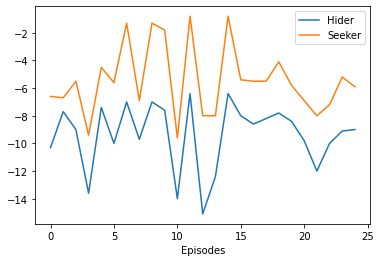

In [12]:
arrEpisodes = np.arange(25)

plt.plot(arrEpisodes, hideRewTot)
plt.plot(arrEpisodes, seekRewTot)
plt.xlabel('Episodes')
plt.legend(["Hider", "Seeker"])
plt.show()

## Actor-Critic 8x8 Gridworld

In [13]:
env = MAGridWorld(8)
hider = ac_agent()
seeker = ac_agent()
testStates = [x for x in range(env.size**2)]
testStates = tf.keras.utils.to_categorical(testStates)
reward_total = list()
actList = [0,0]
hideRewTot = []
seekRewTot= []
winList = []
for epi in range(250):
    obs = env.reset()
    hideTotRew = 0
    seekTotRew = 0
    done = [False, False]
    while not any(done):
        hideCurrPos = obs[0][0]*env.size + obs[0][1]
        actList[0] = hider.step(testStates[hideCurrPos])
        seekCurrPos = obs[1][0]*env.size + obs[1][1]
        actList[1] = seeker.step(testStates[seekCurrPos])
        newObs, reward, done,win, info = env.step(actList)
        hideTotRew += reward[0]
        seekTotRew += reward[1]
        newHidePos = newObs[0][0]*env.size + newObs[0][1]
        newSeekPos = newObs[0][0]*env.size + newObs[0][1]
        hider.learn(testStates[hideCurrPos], reward[0], testStates[newHidePos], done[0])
        seeker.learn(testStates[seekCurrPos], reward[1], testStates[newSeekPos], done[1])
        obs = newObs
        
    hideRewTot.append(hideTotRew)
    seekRewTot.append(seekTotRew)
    winList.append(win)
    
    print("Episode: {}".format(epi))

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Ep

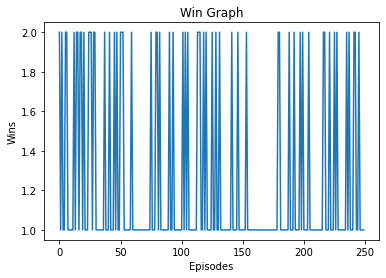

In [14]:
arrEpisodes = np.arange(250)

plt.plot(arrEpisodes, winList)
 
plt.xlabel('Episodes')
plt.ylabel('Wins')
 
plt.title('Win Graph')
 
# function to show the plot
plt.show()

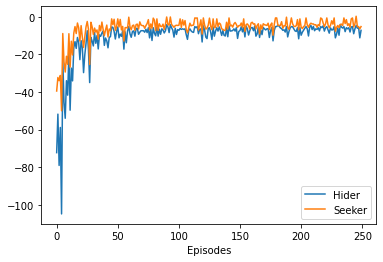

In [15]:
arrEpisodes = np.arange(250)

plt.plot(arrEpisodes, hideRewTot)
plt.plot(arrEpisodes, seekRewTot)
plt.xlabel('Episodes')
plt.legend(["Hider", "Seeker"])
plt.show()

## Actor-Critic 8x8 Evaluation

In [16]:
actList = [0,0]
hideRewTot = []
seekRewTot= []
winList = []
for epi in range(25):
    obs = env.reset()
    hideTotRew = 0
    seekTotRew = 0
    done = [False, False]
    while not any(done):
        hideCurrPos = obs[0][0]*env.size + obs[0][1]
        actList[0] = hider.step(testStates[hideCurrPos])
        seekCurrPos = obs[1][0]*env.size + obs[1][1]
        actList[1] = seeker.step(testStates[seekCurrPos])
        newObs, reward, done,win, info = env.step(actList)
        hideTotRew += reward[0]
        seekTotRew += reward[1]
        
    hideRewTot.append(hideTotRew)
    seekRewTot.append(seekTotRew)
    winList.append(win)
    
    print("Episode: {}".format(epi))

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24


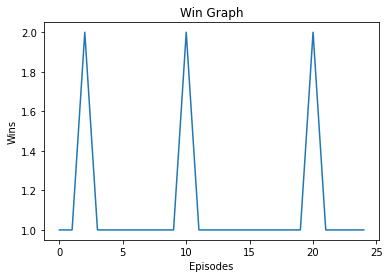

In [17]:
arrEpisodes = np.arange(25)

plt.plot(arrEpisodes, winList)
 
plt.xlabel('Episodes')
plt.ylabel('Wins')
 
plt.title('Win Graph')
 
# function to show the plot
plt.show()

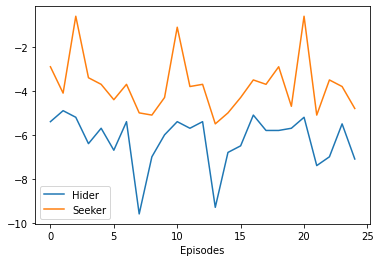

In [18]:
arrEpisodes = np.arange(25)

plt.plot(arrEpisodes, hideRewTot)
plt.plot(arrEpisodes, seekRewTot)
plt.xlabel('Episodes')
plt.legend(["Hider", "Seeker"])
plt.show()

### More Complicated Env

In [19]:
class MAAdvGrid(gym.Env):
    
  metadata = { 'render.modes' : ['human', 'rgb_array'] }
        
  def __init__(self, wallChoice):
    self.size = 10
    self.gridSize = (self.size, self.size)
    self.world = np.zeros((self.gridSize))
    self.timestep = None
    self.maxTimestep = 150
    self.nAgents = 2
    #self.dist = int((self.size-1)/(self.nAgents-1))
    self.stepCost = -0.1
    self.obsSpace = spaces.Box(low=0, high=self.size, shape=(self.size, self.size))
    self.actSpace = spaces.Discrete(5)
    self.choice = wallChoice
        
  def reset(self):
    self.agentPos = []
    self.seekerPos = [0,1]
    self.hidderPos = [self.size-1,self.size-1]
    if self.choice == 0:
        self.walls = [[2,2],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],
                      [3,8],[4,1],[4,8],[5,1],[5,8],[6,1],
                      [6,8],[7,1],[7,2],[7,3],[7,4],[7,5],[7,6]]
        self.wallCount = 20
    elif self.choice == 1:
        self.walls = [[3,2], [2,6], [3,8],[3,7],[7,3],[8,3],
                    [3,1],[6,8],[2,2],[3,6], [1,2], [6,1],[1,6],
                    [6,2],[6,7],[6,3],[6,6],[7,6],[8,6]]
        self.wallCount = 19
    self.goalPos = [0,0]
    self.timestep = 0
    self.done = [False for i in range(self.nAgents)]
    self.agentPos.append(self.hidderPos)
    self.agentPos.append(self.seekerPos)
    #for i in range(self.nAgents):
      #self.agentPos.append([self.size-1, i*self.dist])
      #self.goalPos.append([0, i*self.dist])
      #self.goalPos.reverse()
      #self.goalPos.append([0,2])
    observation = self.agentPos
    return observation
    
  def computeDistance(self, x, y):
    dist = np.abs(x[0]-y[0]) + np.abs(x[1]-y[1])
    return dist
    
  def isInsideGrid(self, pos):
    return (0 <= pos[0] < self.gridSize[0]) and (0 <= pos[1] < self.gridSize[1])

  def isCollision(self, newPos, agent):
    for i in range(self.nAgents):
      if i == agent:
        continue
      elif newPos == self.agentPos[i]:
        return True
      elif (newPos == self.goalPos) and (newPos == self.agentPos[0]):
        return True
    
  def isWallCollision(self, newPos, agent):
    for i in range(self.wallCount):
        if newPos == self.walls[i]:
            #print('true')
            return True
        
  def step(self, actions):
    self.timestep += 1
    #win will be -1 if not done, 0 if a tie, 1 if hider wins, and 2 if seeker wins
    win = -1
    oldPos = self.agentPos.copy()
    #print(oldPos)
    rewards = [0 for _ in range(self.nAgents)]               

    for i in range(self.nAgents):
      #print(self.nAgents)
      if (self.done[0] == True) or (self.done[1] == True):
        print("One or both agents are done")
        break
      #Hider Agent
      if i == 0:
        #print("hider")
        self.updatePos(0, actions[0])
        oldDist = self.computeDistance(oldPos[0], self.goalPos)
        goalDist = self.computeDistance(self.agentPos[0], self.goalPos)
        seekerDist = self.computeDistance(self.agentPos[0], self.agentPos[1])
        oldSeekDist = self.computeDistance(oldPos[0], self.agentPos[1])

        if goalDist < oldDist:
          rewards[0] += -0.1
        elif goalDist > oldDist:
          rewards[0] += -0.5
        elif (goalDist == oldDist) and not self.done[i]:
          rewards[0] += -0.5
            
        if seekerDist < oldDist:
          rewards[0] += -0.5
        elif seekerDist > oldDist:
          rewards[0] += -0.1

        if (self.agentPos[0] == self.goalPos):
          self.done[0] = True
          win = 1
          rewards[0] += 1
        elif (self.agentPos[0] == self.agentPos[1]):
          self.done[0] = True
          rewards[0] += -1
          win = 2
        else:
          self.done[0] = False
      #Move Seeker
      elif i == 1:
        #print('Seeker')
        self.updatePos(1, actions[1])
        #Measure the distance between the hider and seeker
        oldDist = self.computeDistance(oldPos[1], self.agentPos[0])
        newDist = self.computeDistance(self.agentPos[1], self.agentPos[0])

        if newDist < oldDist:
          rewards[1] += -0.1
        elif newDist > oldDist:
          rewards[1] += -0.5
        elif (newDist == oldDist) and not self.done[i]:
          rewards[1] += -0.5

        if (self.agentPos[1] == self.agentPos[0]):
          #print('here')
          self.done[1] = True
          rewards[1] += 1
          win = 2
        else:
          self.done[1] = False
      else:
        print('Not the agent, dummy')
                    
    #print("p")       
    if self.timestep >= self.maxTimestep:
      self.done = [True for i in range(self.nAgents)]
      win = 0
            
    observation = self.agentPos
    info = {}
    return observation, rewards, self.done, win, info #all(done)
    
        
  def updatePos(self, agent, action):
    nextPos = copy(self.agentPos[agent])
    if action == 0: # Down
      nextPos[0] += 1
    elif action == 1: # Up
      nextPos[0] -= 1
    elif action == 2: # Right
      nextPos[1] += 1
    elif action == 3: # Left
      nextPos[1] -= 1
    elif action == 4: # No move
      pass
    else:
      raise Exception('Action is not valid')
        
    if self.isCollision(nextPos, agent):
      for i in range(self.nAgents):  
        self.done[i] = True
    if self.isInsideGrid(nextPos) and (not self.isWallCollision(nextPos, agent)):
      self.agentPos[agent] = nextPos
    else:
      pass
        
            
  def render(self):
    state = np.copy(self.world)
    for i in range(self.nAgents):
      state[tuple(self.agentPos[i])] = 1 - (0.1 * i)
    state[tuple(self.goalPos)] = 1 - (0.1 * 0)
    #tate[self.walls] = .5
    for i in range(self.wallCount):
      state[tuple(self.walls[i])] = 0.5
    return plt.imshow(state)

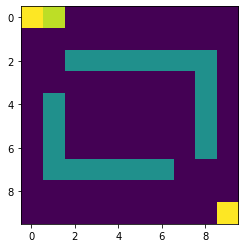

In [20]:
env = MAAdvGrid(0)
env.reset()
env.render()

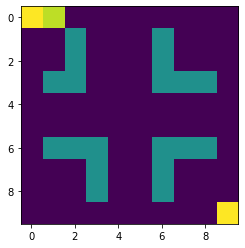

In [21]:
env = MAAdvGrid(1)
env.reset()
env.render()

## Advanced Env. 1: Actor-Critic

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
One or both agents are done
Episode: 5
One or both agents are done
Episode: 6
One or both agents are done
Episode: 7
Episode: 8
Episode: 9
One or both agents are done
Episode: 10
One or both agents are done
Episode: 11
Episode: 12
Episode: 13
One or both agents are done
Episode: 14
One or both agents are done
Episode: 15
One or both agents are done
Episode: 16
One or both agents are done
Episode: 17
One or both agents are done
Episode: 18
One or both agents are done
Episode: 19
One or both agents are done
Episode: 20
One or both agents are done
Episode: 21
One or both agents are done
Episode: 22
One or both agents are done
Episode: 23
One or both agents are done
Episode: 24
One or both agents are done
Episode: 25
One or both agents are done
Episode: 26
One or both agents are done
Episode: 27
One or both agents are done
Episode: 28
One or both agents are done
Episode: 29
One or both agents are done
Episode: 30
One or both agents are

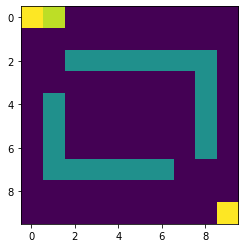

In [22]:
hider = ac_agent()
seeker = ac_agent()
env = MAAdvGrid(0)
testStates = [x for x in range(env.size**2)]
testStates = tf.keras.utils.to_categorical(testStates)
reward_total = list()
actList = [0,0]
hideRewTot = []
seekRewTot= []
winList = []
for epi in range(250):
    obs = env.reset()
    hideTotRew = 0
    seekTotRew = 0
    done = [False, False]
    while not any(done):
        hideCurrPos = obs[0][0]*env.size + obs[0][1]
        actList[0] = hider.step(testStates[hideCurrPos])
        seekCurrPos = obs[1][0]*env.size + obs[1][1]
        actList[1] = seeker.step(testStates[seekCurrPos])
        newObs, reward, done,win, info = env.step(actList)
        hideTotRew += reward[0]
        seekTotRew += reward[1]
        newHidePos = newObs[0][0]*env.size + newObs[0][1]
        newSeekPos = newObs[0][0]*env.size + newObs[0][1]
        hider.learn(testStates[hideCurrPos], reward[0], testStates[newHidePos], done[0])
        seeker.learn(testStates[seekCurrPos], reward[1], testStates[newSeekPos], done[1])
        obs = newObs
        
    hideRewTot.append(hideTotRew)
    seekRewTot.append(seekTotRew)
    winList.append(win)
    
    print("Episode: {}".format(epi))
    env.reset()
    env.render()

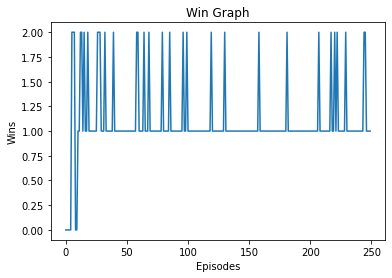

In [23]:
arrEpisodes = np.arange(250)

plt.plot(arrEpisodes, winList)
 
plt.xlabel('Episodes')
plt.ylabel('Wins')
 
plt.title('Win Graph')
 
# function to show the plot
plt.show()

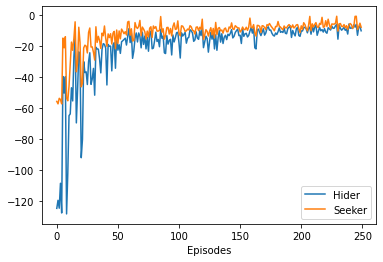

In [24]:
arrEpisodes = np.arange(250)

plt.plot(arrEpisodes, hideRewTot)
plt.plot(arrEpisodes, seekRewTot)
plt.xlabel('Episodes')
plt.legend(["Hider", "Seeker"])
plt.show()

## Advanced Env. 1: Actor-Critic Eval

In [25]:
actList = [0,0]
hideRewTot = []
seekRewTot= []
winList = []
for epi in range(25):
    obs = env.reset()
    hideTotRew = 0
    seekTotRew = 0
    done = [False, False]
    while not any(done):
        hideCurrPos = obs[0][0]*env.size + obs[0][1]
        actList[0] = hider.step(testStates[hideCurrPos])
        seekCurrPos = obs[1][0]*env.size + obs[1][1]
        actList[1] = seeker.step(testStates[seekCurrPos])
        newObs, reward, done,win, info = env.step(actList)
        hideTotRew += reward[0]
        seekTotRew += reward[1]
        
    hideRewTot.append(hideTotRew)
    seekRewTot.append(seekTotRew)
    winList.append(win)
    
    print("Episode: {}".format(epi))

One or both agents are done
Episode: 0
Episode: 1
One or both agents are done
Episode: 2
One or both agents are done
Episode: 3
One or both agents are done
Episode: 4
One or both agents are done
Episode: 5
One or both agents are done
Episode: 6
One or both agents are done
Episode: 7
One or both agents are done
Episode: 8
One or both agents are done
Episode: 9
One or both agents are done
Episode: 10
One or both agents are done
Episode: 11
One or both agents are done
Episode: 12
One or both agents are done
Episode: 13
One or both agents are done
Episode: 14
One or both agents are done
Episode: 15
One or both agents are done
Episode: 16
One or both agents are done
Episode: 17
One or both agents are done
Episode: 18
One or both agents are done
Episode: 19
One or both agents are done
Episode: 20
One or both agents are done
Episode: 21
One or both agents are done
Episode: 22
One or both agents are done
Episode: 23
One or both agents are done
Episode: 24


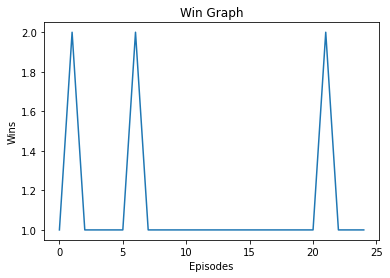

In [26]:
arrEpisodes = np.arange(25)

plt.plot(arrEpisodes, winList)
 
plt.xlabel('Episodes')
plt.ylabel('Wins')
 
plt.title('Win Graph')
 
# function to show the plot
plt.show()

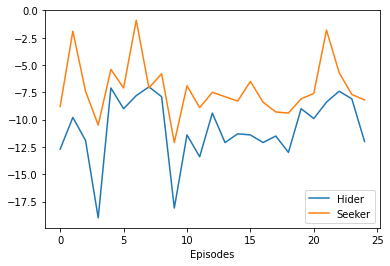

In [27]:
arrEpisodes = np.arange(25)

plt.plot(arrEpisodes, hideRewTot)
plt.plot(arrEpisodes, seekRewTot)
plt.xlabel('Episodes')
plt.legend(["Hider", "Seeker"])
plt.show()

## Advanced Env. 2: Actor Critic

In [28]:
hider = ac_agent()
seeker = ac_agent()
env = MAAdvGrid(1)
testStates = [x for x in range(env.size**2)]
testStates = tf.keras.utils.to_categorical(testStates)
reward_total = list()
actList = [0,0]
hideRewTot = []
seekRewTot= []
winList = []
for epi in range(700):
    obs = env.reset()
    hideTotRew = 0
    seekTotRew = 0
    done = [False, False]
    while not any(done):
        hideCurrPos = obs[0][0]*env.size + obs[0][1]
        actList[0] = hider.step(testStates[hideCurrPos])
        seekCurrPos = obs[1][0]*env.size + obs[1][1]
        actList[1] = seeker.step(testStates[seekCurrPos])
        newObs, reward, done,win, info = env.step(actList)
        hideTotRew += reward[0]
        seekTotRew += reward[1]
        newHidePos = newObs[0][0]*env.size + newObs[0][1]
        newSeekPos = newObs[0][0]*env.size + newObs[0][1]
        hider.learn(testStates[hideCurrPos], reward[0], testStates[newHidePos], done[0])
        seeker.learn(testStates[seekCurrPos], reward[1], testStates[newSeekPos], done[1])
        obs = newObs
        
    hideRewTot.append(hideTotRew)
    seekRewTot.append(seekTotRew)
    winList.append(win)
    
    print("Episode: {}".format(epi))

Episode: 0
Episode: 1
Episode: 2
One or both agents are done
Episode: 3
One or both agents are done
Episode: 4
One or both agents are done
Episode: 5
One or both agents are done
Episode: 6
Episode: 7
Episode: 8
One or both agents are done
Episode: 9
Episode: 10
One or both agents are done
Episode: 11
One or both agents are done
Episode: 12
Episode: 13
One or both agents are done
Episode: 14
Episode: 15
One or both agents are done
Episode: 16
One or both agents are done
Episode: 17
One or both agents are done
Episode: 18
One or both agents are done
Episode: 19
One or both agents are done
Episode: 20
Episode: 21
One or both agents are done
Episode: 22
Episode: 23
One or both agents are done
Episode: 24
One or both agents are done
Episode: 25
Episode: 26
Episode: 27
One or both agents are done
Episode: 28
One or both agents are done
Episode: 29
One or both agents are done
Episode: 30
Episode: 31
One or both agents are done
Episode: 32
Episode: 33
One or both agents are done
Episode: 34
Ep

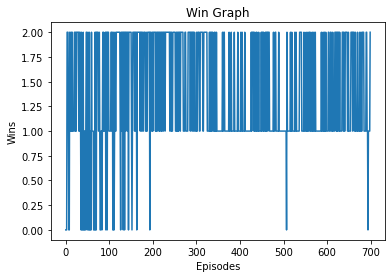

In [29]:
arrEpisodes = np.arange(700)

plt.plot(arrEpisodes, winList)
 
plt.xlabel('Episodes')
plt.ylabel('Wins')
 
plt.title('Win Graph')
 
# function to show the plot
plt.show()

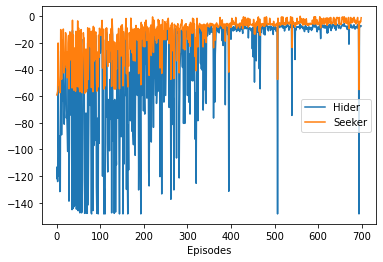

In [30]:
arrEpisodes = np.arange(700)

plt.plot(arrEpisodes, hideRewTot)
plt.plot(arrEpisodes, seekRewTot)
plt.xlabel('Episodes')
plt.legend(["Hider", "Seeker"])
plt.show()

## Advanced Env. 2: Actor Critic Eval

In [31]:
actList = [0,0]
hideRewTot = []
seekRewTot= []
winList = []
for epi in range(25):
    obs = env.reset()
    hideTotRew = 0
    seekTotRew = 0
    done = [False, False]
    while not any(done):
        hideCurrPos = obs[0][0]*env.size + obs[0][1]
        actList[0] = hider.step(testStates[hideCurrPos])
        seekCurrPos = obs[1][0]*env.size + obs[1][1]
        actList[1] = seeker.step(testStates[seekCurrPos])
        newObs, reward, done,win, info = env.step(actList)
        hideTotRew += reward[0]
        seekTotRew += reward[1]
        
    hideRewTot.append(hideTotRew)
    seekRewTot.append(seekTotRew)
    winList.append(win)
    
    print("Episode: {}".format(epi))

One or both agents are done
Episode: 0
One or both agents are done
Episode: 1
One or both agents are done
Episode: 2
One or both agents are done
Episode: 3
One or both agents are done
Episode: 4
One or both agents are done
Episode: 5
One or both agents are done
Episode: 6
One or both agents are done
Episode: 7
One or both agents are done
Episode: 8
One or both agents are done
Episode: 9
One or both agents are done
Episode: 10
One or both agents are done
Episode: 11
One or both agents are done
Episode: 12
One or both agents are done
Episode: 13
One or both agents are done
Episode: 14
One or both agents are done
Episode: 15
One or both agents are done
Episode: 16
One or both agents are done
Episode: 17
One or both agents are done
Episode: 18
One or both agents are done
Episode: 19
Episode: 20
One or both agents are done
Episode: 21
One or both agents are done
Episode: 22
Episode: 23
One or both agents are done
Episode: 24


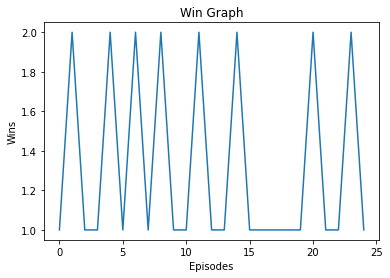

In [32]:
arrEpisodes = np.arange(25)

plt.plot(arrEpisodes, winList)
 
plt.xlabel('Episodes')
plt.ylabel('Wins')
 
plt.title('Win Graph')
 
# function to show the plot
plt.show()

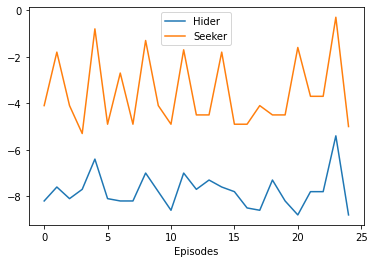

In [33]:
arrEpisodes = np.arange(25)

plt.plot(arrEpisodes, hideRewTot)
plt.plot(arrEpisodes, seekRewTot)
plt.xlabel('Episodes')
plt.legend(["Hider", "Seeker"])
plt.show()